## Imports

In [1]:
from pyspark.sql import DataFrame, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType, LongType, DoubleType, ArrayType, DateType
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql.types import ArrayType, StringType, MapType, IntegerType

## Create Spark session

In [2]:
from dtu_ctfds_02807_proj.context_creation import create_context

local = True
sc, spark = create_context(local)

Cell has not been executed before, running...


24/11/18 00:09:49 WARN Utils: Your hostname, macbook.local resolves to a loopback address: 127.0.0.1; using 192.168.86.53 instead (on interface en0)
24/11/18 00:09:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/18 00:09:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load data

In [3]:
review_schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("app_id", LongType(), True),
    StructField("app_name", StringType(), True),
    StructField("review_id", LongType(), True),
    StructField("language", StringType(), True),
    StructField("review", StringType(), True),
    StructField("timestamp_created", IntegerType(), True),
    StructField("timestamp_updated", IntegerType(), True),
    StructField("recommended", BooleanType(), True),
    StructField("votes_helpful", IntegerType(), True),
    StructField("votes_funny", IntegerType(), True),
    StructField("weighted_vote_score", DoubleType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("steam_purchase", BooleanType(), True),
    StructField("received_for_free", BooleanType(), True),
    StructField("written_during_early_access", BooleanType(), True),
    StructField("author_steamid", LongType(), True),
    StructField("author_num_games_owned", IntegerType(), True),
    StructField("author_num_reviews", IntegerType(), True),
    StructField("author_playtime_forever", DoubleType(), True),
    StructField("author_playtime_last_two_weeks", DoubleType(), True),
    StructField("author_playtime_at_review", DoubleType(), True),
    StructField("author_last_played", DoubleType(), True)
])

In [4]:
game_schema = StructType([
    StructField("app_id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("release_date", DateType(), True),
    StructField("required_age", IntegerType(), True),
    StructField("price", FloatType(), True),
    StructField("dlc_count", IntegerType(), True),
    StructField("detailed_description", StringType(), True),
    StructField("about_the_game", StringType(), True),
    StructField("short_description", StringType(), True),
    StructField("reviews", StringType(), True),
    StructField("header_image", StringType(), True),
    StructField("website", StringType(), True),
    StructField("support_url", StringType(), True),
    StructField("support_email", StringType(), True),
    StructField("windows", BooleanType(), True),
    StructField("mac", BooleanType(), True),
    StructField("linux", BooleanType(), True),
    StructField("metacritic_score", IntegerType(), True),
    StructField("metacritic_url", StringType(), True),
    StructField("achievements", IntegerType(), True),
    StructField("recommendations", IntegerType(), True),
    StructField("notes", StringType(), True),
    StructField("supported_languages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("full_audio_languages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("packages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("developers", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("publishers", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("categories", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("genres", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("screenshots", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("movies", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("user_score", FloatType(), True),
    StructField("score_rank", IntegerType(), True),
    StructField("positive", IntegerType(), True),
    StructField("negative", IntegerType(), True),
    StructField("estimated_owners", StringType(), True),
    StructField("average_playtime_forever", IntegerType(), True),
    StructField("average_playtime_2weeks", IntegerType(), True),
    StructField("median_playtime_forever", IntegerType(), True),
    StructField("median_playtime_2weeks", IntegerType(), True),
    StructField("peak_ccu", IntegerType(), True),
    StructField("tags", MapType(StringType(), IntegerType()), True),  # Parsed from JSON
    StructField("pct_pos_total", IntegerType(), True),
    StructField("num_reviews_total", IntegerType(), True),
    StructField("pct_pos_recent", IntegerType(), True),
    StructField("num_reviews_recent", IntegerType(), True)
])

In [5]:

if local:
    game_reviews = spark.read.parquet("data/steam_reviews_sample_parquet")
    games = spark.read.parquet("data/steam_games_parquet")
else:
    game_reviews = spark.read.parquet("file:////work/ds/steam_reviews_parquet")
    games = spark.read.parquet('file:////work/ds/steam_games_parquet')
    

game_reviews: DataFrame = game_reviews.persist()
games: DataFrame = games.persist()

In [6]:
game_reviews\
    .select(game_reviews.app_id)\
    .distinct()\
    .count()

315

In [7]:
game_reviews\
    .show(5)

+-------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|  index|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+-------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----

In [8]:
game_reviews\
    .select(game_reviews.app_id)\
    .filter(game_reviews.language == 'english')\
    .count()

46020

## Most reviewed games

In [9]:
most_reviewed = game_reviews\
    .groupBy(game_reviews.app_id)\
    .agg(
        F.count('review_id').alias('review_count'),
        F.count(
            F.when(game_reviews.recommended == True, 1)
        ).alias('recommended_count'),
        F.count(
            F.when(game_reviews.recommended == False, 1)
        ).alias('not_recommended_count')
    )\
    .withColumn(
        'recommended_ratio',
        F.col('recommended_count') / F.col('review_count')
    )\
    .withColumn(
        'not_recommended_ratio',
        F.col('not_recommended_count') / F.col('review_count')
    )\
    .withColumn(
        'recommended_to_not_recommended_ratio',
        F.col('recommended_count') / F.col('not_recommended_count')
    )

most_reviewed_games = most_reviewed\
    .join(games, most_reviewed.app_id == games.app_id, how='inner')


In [10]:
most_reviewed_games\
    .select('name', 'review_count', 'recommended_ratio', 'recommended_to_not_recommended_ratio')\
    .orderBy(F.desc('review_count'))\
    .show(
        5,
        truncate=False
    )

+-------------------------------+------------+------------------+------------------------------------+
|name                           |review_count|recommended_ratio |recommended_to_not_recommended_ratio|
+-------------------------------+------------+------------------+------------------------------------+
|PUBG: BATTLEGROUNDS            |7835        |0.5392469687300574|1.1703601108033241                  |
|Grand Theft Auto V             |4913        |0.8155912884184816|4.422737306843267                   |
|Tom Clancy's Rainbow Six® Siege|3981        |0.8839487565938207|7.616883116883117                   |
|Terraria                       |3084        |0.9727626459143969|35.714285714285715                  |
|Garry's Mod                    |3079        |0.9600519649236765|24.03252032520325                   |
+-------------------------------+------------+------------------+------------------------------------+
only showing top 5 rows



In [11]:
most_reviewed_games\
    .select('name', 'review_count', 'recommended_ratio', 'recommended_to_not_recommended_ratio')\
    .filter(F.col('recommended_to_not_recommended_ratio').isNotNull())\
    .filter(F.col('review_count') > 100)\
    .orderBy(F.asc('recommended_to_not_recommended_ratio'))\
    .show(
        5,
        truncate=False
    )

+-------------------+------------+------------------+------------------------------------+
|name               |review_count|recommended_ratio |recommended_to_not_recommended_ratio|
+-------------------+------------+------------------+------------------------------------+
|ATLAS              |192         |0.4791666666666667|0.92                                |
|Call of Duty®: WWII|141         |0.524822695035461 |1.1044776119402986                  |
|PUBG: BATTLEGROUNDS|7835        |0.5392469687300574|1.1703601108033241                  |
|Artifact           |113         |0.5575221238938053|1.26                                |
|No Man's Sky       |896         |0.6796875         |2.1219512195121952                  |
+-------------------+------------+------------------+------------------------------------+
only showing top 5 rows



## Review count by user

In [12]:
reviews_by_user = game_reviews\
    .groupBy("author_steamid")\
    .agg(
        F.count('review_id').alias('review_count'),
    )

user_review_count = reviews_by_user\
    .groupBy("review_count")\
    .agg(
        F.count('review_count').alias('user_count'),
    )\
    .orderBy(F.desc('review_count'))

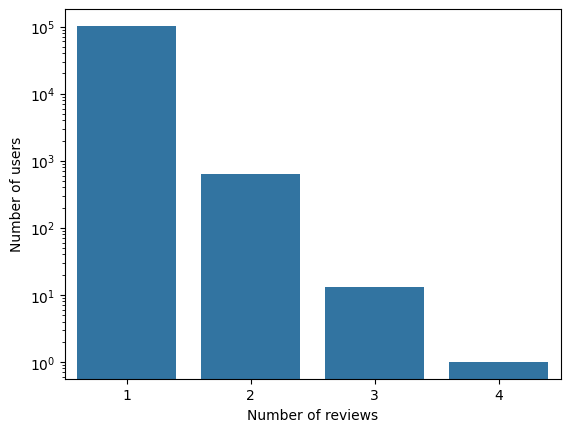

In [13]:
user_review_count_pd = user_review_count.toPandas()

# Only discrete values, log y-axis
sns.barplot(
    x=user_review_count_pd['review_count'],
    y=user_review_count_pd['user_count'],
    log=True
)
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')

plt.show()

## Histogram of review_count

In [14]:
most_reviewed_games_pdf = most_reviewed_games.toPandas()

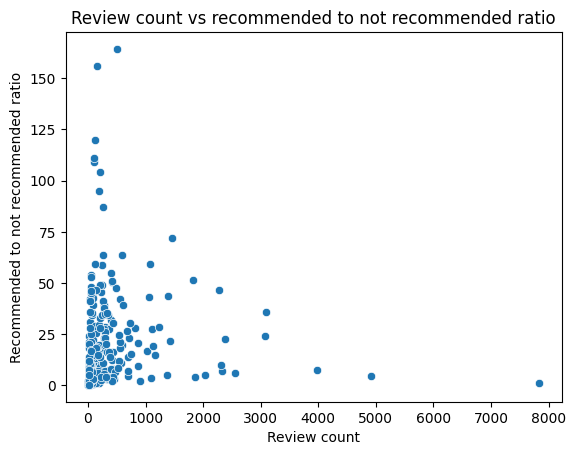

In [15]:
sns.scatterplot(
    x='review_count',
    y='recommended_to_not_recommended_ratio',
    data=most_reviewed_games_pdf
)

plt.xlabel('Review count')
plt.ylabel('Recommended to not recommended ratio')
plt.title('Review count vs recommended to not recommended ratio')
plt.show()

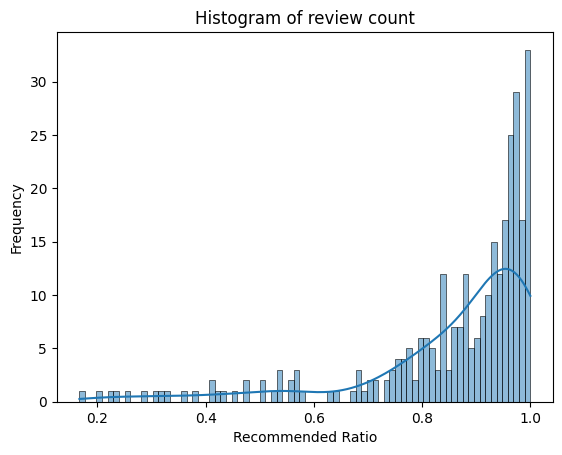

In [16]:
sns.histplot(
    most_reviewed_games_pdf['recommended_ratio'],
    bins=80,
    kde=True
)
plt.xlabel('Recommended Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of review count')
plt.show()

In [17]:
game_reviews\
    .filter(game_reviews.author_steamid > 100)\
    .groupBy(game_reviews.app_id, game_reviews.author_steamid)\
    .agg(
        F.count('review_id').alias('review_count'),
    )\
    .orderBy(F.desc('review_count'))\
    .show(
        5
    )

+-------+-----------------+------------+
| app_id|   author_steamid|review_count|
+-------+-----------------+------------+
| 367520|76561198988312667|           2|
| 227300|76561198079793673|           2|
| 779340|76561198156707503|           1|
| 779340|76561198022192588|           1|
|1190460|76561198080232836|           1|
+-------+-----------------+------------+
only showing top 5 rows



# Collaborative filtering

## ALS model

In [18]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer

game_ratings = game_reviews\
    .filter(F.col("author_steamid").isNotNull())\
    .withColumn(
        'rating',
        F.when(game_reviews.recommended == True, 1).otherwise(-1)
    )

user_indexer = StringIndexer(inputCol="author_steamid", outputCol="user_index")
game_ratings = user_indexer.fit(game_ratings).transform(game_ratings)

reviews_train, reviews_test = game_ratings\
    .randomSplit([0.8, 0.2], seed=1234)

als = ALS(
    maxIter=50,
    rank=20,
    regParam=0.01,
    userCol="user_index",
    itemCol="app_id",
    ratingCol="rating",
    coldStartStrategy="drop"
)

In [19]:
model = als.fit(reviews_train)

predictions = model.transform(reviews_test).cache()

In [20]:
# Round predictions to -1 or 1
rounded_pred = predictions\
    .withColumn(
        'prediction',
        F.when(F.col('prediction') > 0, 1.).otherwise(-1.)
    )\
    .select('rating', 'prediction')\

rounded_pred.show(5)

+------+----------+
|rating|prediction|
+------+----------+
|     1|       1.0|
|     1|      -1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 5 rows



In [21]:
# Calculate RMSE
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(rounded_pred)
print(f"Root-mean-square error = {rmse}")

# Calculate accuracy
correct = rounded_pred\
    .filter(F.col('rating') == F.col('prediction'))\
    .count()

total = rounded_pred.count()

accuracy = correct / total

print(f"Accuracy = {accuracy}")

Root-mean-square error = 1.342030968502161


Accuracy = 0.5497382198952879


# Content based filtering

In [22]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, BucketedRandomProjectionLSH, BucketedRandomProjectionLSHModel, MinHashLSH, MinHashLSHModel
from pyspark.ml import Pipeline

In [52]:
game_data = games\
    .filter(games.detailed_description.isNotNull())\
    .select('app_id', 'name', 'about_the_game', 'detailed_description', 'short_description')

tokenizer = Tokenizer(inputCol="detailed_description", outputCol="words")

stop_word_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)

idf = IDF(inputCol="rawFeatures", outputCol="features")

brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=10.0)

pipeline = Pipeline(stages=[tokenizer, stop_word_remover, hashingTF, idf, brp])


In [53]:
model = pipeline.fit(game_data)

In [54]:
result = model.transform(game_data)

In [55]:
brp_model: BucketedRandomProjectionLSHModel = model.stages[-1]

In [59]:
query_vector = result\
    .where(F.col('app_id') == 100)\
    .select('features')\
    .first()["features"]

brp_model\
    .approxNearestNeighbors(
        dataset=result, 
        key=query_vector,
        numNearestNeighbors=5,
        distCol="EuclideanDistance" 
    )\
    .select('app_id', 'name', 'EuclideanDistance')\
    .show(truncate=False)

+------+------------------------------+------------------+
|app_id|name                          |EuclideanDistance |
+------+------------------------------+------------------+
|100   |Counter-Strike: Condition Zero|0.0               |
|80    |Counter-Strike: Condition Zero|0.0               |
|9900  |Star Trek Online              |12.928798476622445|
|109600|Neverwinter                   |12.928798476622445|
|342570|HIS (Heroes In the Sky)       |13.20559249655457 |
+------+------------------------------+------------------+



In [ ]:
left = result.alias("left")
right = result.alias("right")

similar_games = brp_model\
    .approxSimilarityJoin(
        left, right, threshold=0.0, distCol="EuclideanDistance"
    )\
    .filter(F.col("datasetA.app_id") < F.col("datasetB.app_id"))\
    
similar_games\
    .select(
        "datasetA.app_id",
        "datasetB.app_id",
        "EuclideanDistance"
    ).show()



[287.854s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 463.0 (TID 1964): Retried waiting for GCLocker too often allocating 256 words
[287.915s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 468.0 (TID 1974): Retried waiting for GCLocker too often allocating 256 words
[287.915s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 458.0 (TID 1954): Retried waiting for GCLocker too often allocating 389 words
[289.911s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 458.0 (TID 1955): Retried waiting for GCLocker too often allocating 38 words
[290.111s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 468.0 (TID 1975): Retried waiting for GCLocker too often allocating 430 words
[290.112s][warning][gc,alloc] Executor task launch worker for task 0.0 in stage 458.0 (TID 1954): Retried waiting for GCLocker too often allocating 416 words
[290.176s][warning][gc,alloc] Executor task launch wo

24/11/17 20:47:30 ERROR Utils: uncaught error in thread spark-listener-group-appStatus, stopping SparkContext
java.lang.OutOfMemoryError: Java heap space
24/11/17 20:47:30 ERROR Utils: throw uncaught fatal error in thread spark-listener-group-appStatus
java.lang.OutOfMemoryError: Java heap space
Exception in thread "spark-listener-group-appStatus" java.lang.OutOfMemoryError: Java heap space
24/11/17 20:47:30 ERROR Executor: Exception in task 1.0 in stage 458.0 (TID 1955)
java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.sql.catalyst.expressions.UnsafeArrayData.toDoubleArray(UnsafeArrayData.java:414)
	at org.apache.spark.ml.linalg.VectorUDT.deserialize(VectorUDT.scala:63)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$SpecificSafeProjection.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.encoders.ExpressionEncoder$Deserializer.apply(ExpressionEncoder.scala:188)
	at org.apache.spark.sql.catalyst.expressions.ScalaUDF.$anonfun$scalaConverter$2(ScalaUDF.

Py4JJavaError: An error occurred while calling o497.showString.
: org.apache.spark.SparkException: Job 36 cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$cleanUpAfterSchedulerStop$1$adapted(DAGScheduler.scala:1251)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:1251)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:3087)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$stop$3(DAGScheduler.scala:2973)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:2973)
	at org.apache.spark.SparkContext.$anonfun$stop$12(SparkContext.scala:2258)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1375)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2258)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:2211)
	at org.apache.spark.SparkContext$$anon$3.run(SparkContext.scala:2198)


In [22]:
games.printSchema()

root
 |-- app_id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- required_age: integer (nullable = true)
 |-- price: float (nullable = true)
 |-- dlc_count: integer (nullable = true)
 |-- detailed_description: string (nullable = true)
 |-- about_the_game: string (nullable = true)
 |-- short_description: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- header_image: string (nullable = true)
 |-- website: string (nullable = true)
 |-- support_url: string (nullable = true)
 |-- support_email: string (nullable = true)
 |-- windows: boolean (nullable = true)
 |-- mac: boolean (nullable = true)
 |-- linux: boolean (nullable = true)
 |-- metacritic_score: integer (nullable = true)
 |-- metacritic_url: string (nullable = true)
 |-- achievements: integer (nullable = true)
 |-- recommendations: integer (nullable = true)
 |-- notes: string (nullable = true)
 |-- supported_languages: array (nullable = true)
 |    |-- el

In [65]:

# Select relevant columns for content-based filtering
game_data = games\
    .where(games.detailed_description.isNotNull())\
    .select("app_id", "name", "genres", "detailed_description")

# Preprocessing pipeline
# Tokenize the detailed description
tokenizer = Tokenizer(inputCol="detailed_description", outputCol="tokens")

# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Apply TF (Term Frequency)
hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=20)

# Apply IDF (Inverse Document Frequency)
idf = IDF(inputCol="raw_features", outputCol="features")

# Locality Sensitive Hashing (LSH) for similarity search
minhash_lsh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)

# Build the pipeline
pipeline = Pipeline(stages=[
    tokenizer,
    stopwords_remover,
    hashing_tf,
    idf,
    minhash_lsh
])


In [66]:
# Fit the pipeline to the data
model = pipeline.fit(game_data)
processed_games_df = model.transform(game_data)

In [67]:
# Show the processed data
# processed_games_df.select("app_id", "name", "hashes").show(truncate=False)

# Example: Finding similar games based on detailed description
# Choose a game to find similar ones
sample_game = processed_games_df.filter(games.app_id == 80).limit(1)
sample_game_features = sample_game.select("features").first()["features"]

sample_game.show(truncate=False)

mh_model: MinHashLSHModel = model.stages[-1]

# Perform the similarity search
mh_model.approxNearestNeighbors(
    dataset=processed_games_df, key=sample_game_features, numNearestNeighbors=10, distCol="JaccardDistance"
)\
    .orderBy(F.asc("JaccardDistance"))\
    .show(truncate=False)

# similar_games = mh_model.approxSimilarityJoin(
#     processed_games_df, sample_game, 2.0, distCol="JaccardDistance"
# )

# # Show similar games
# similar_games\
#     .select("datasetA.name", "datasetB.name", "JaccardDistance")\
#     .orderBy(F.asc("JaccardDistance"))\
#     .show(truncate=False)

+------+------------------------------+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------

+-------+------------------------------+-------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------